# SSIP 2021 - Age recognition project

Recognizing the age of person based on the facial image (the age can be recognized within several classes: teenager, young, middle age, old).

Input: A digital image of a face.  
Output: Age of person in the image.  
Datasets: https://www.face-rec.org/databases/


## Resizing images


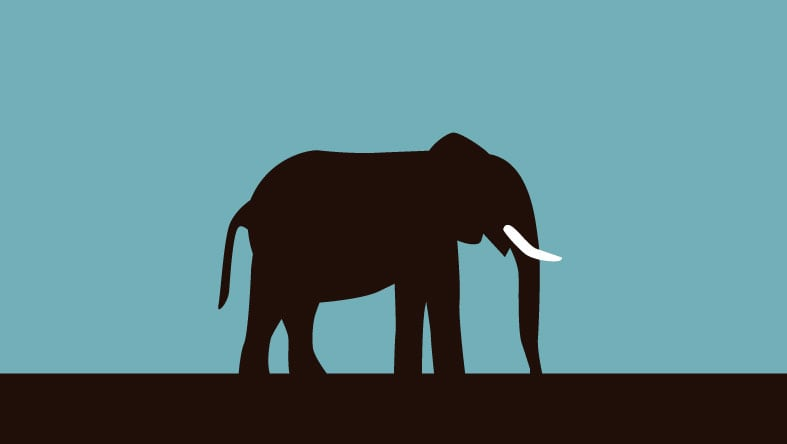

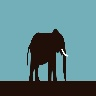

In [17]:
import cv2
 
# Resizing images
src = cv2.imread('/content/data/images/images_original/random.jpg')

output = cv2.resize(src, (96, 96))

cv2.imwrite('/content/data/images/images_96x96/random.jpg', output) 


# Showing images
from google.colab.patches import cv2_imshow

src = cv2.imread('/content/data/images/images_original/random.jpg')
cv2_imshow(src)

src2 = cv2.imread('/content/data/images/images_96x96/random.jpg')
cv2_imshow(src2)